# 102 Flowers Classification using ResNet50


In [3]:
%%bash
# Check if wget and tar are available
command -v wget >/dev/null 2>&1 || { echo >&2 "wget is required but it's not installed. Aborting."; exit 1; }
command -v tar >/dev/null 2>&1 || { echo >&2 "tar is required but it's not installed. Aborting."; exit 1; }

# Downloading all the data using wget command if not already downloaded
[ ! -f setid.mat ] && wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat'
[ ! -f imagelabels.mat ] && wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat'
[ ! -f 102flowers.tgz ] && wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'

# Extracting the data from archived files if not already extracted
[ -f 102flowers.tgz ] && tar xvf 102flowers.tgz

# Removing the useless archived file
[ -f 102flowers.tgz ] && rm -rf 102flowers.tgz

jpg/
jpg/image_00009.jpg
jpg/image_01701.jpg
jpg/image_01890.jpg
jpg/image_00623.jpg
jpg/image_03604.jpg
jpg/image_00190.jpg
jpg/image_02534.jpg
jpg/image_01087.jpg
jpg/image_07599.jpg
jpg/image_02407.jpg
jpg/image_04357.jpg
jpg/image_00094.jpg
jpg/image_03564.jpg
jpg/image_03988.jpg
jpg/image_03558.jpg
jpg/image_06930.jpg
jpg/image_04118.jpg
jpg/image_00882.jpg
jpg/image_07247.jpg
jpg/image_05384.jpg
jpg/image_06602.jpg
jpg/image_05924.jpg
jpg/image_04827.jpg
jpg/image_06629.jpg
jpg/image_04726.jpg
jpg/image_07200.jpg
jpg/image_01832.jpg
jpg/image_00390.jpg
jpg/image_04449.jpg
jpg/image_06970.jpg
jpg/image_03975.jpg
jpg/image_06230.jpg
jpg/image_01821.jpg
jpg/image_03326.jpg
jpg/image_00902.jpg
jpg/image_02102.jpg
jpg/image_04985.jpg
jpg/image_03433.jpg
jpg/image_07634.jpg
jpg/image_06699.jpg
jpg/image_02496.jpg
jpg/image_00373.jpg
jpg/image_02290.jpg
jpg/image_06901.jpg
jpg/image_04583.jpg
jpg/image_06162.jpg
jpg/image_01681.jpg
jpg/image_02275.jpg
jpg/image_01348.jpg
jpg/image_00280

# Importing Necessary Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import os
from tqdm.auto import tqdm
import seaborn as sns
from scipy.io import loadmat
import shutil
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torch.optim as optim

# Ensure the log directory exists
log_dir = os.path.dirname('logs.log')
if log_dir and not os.path.exists(log_dir):
    os.makedirs(log_dir)

logging.basicConfig(filename='logs.log', level=logging.INFO)

--2024-07-27 10:49:07--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/setid.mat [following]
--2024-07-27 10:49:07--  https://thor.robots.ox.ac.uk/flowers/102/setid.mat
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14989 (15K) [application/octet-stream]
Saving to: ‘setid.mat’

     0K .......... ....                                       100%  245M=0s

2024-07-27 10:49:08 (245 MB/s) - ‘setid.mat’ saved [14989/14989]

--2024-07-27 10:49:08--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.rob

# Data Processing and Visualization


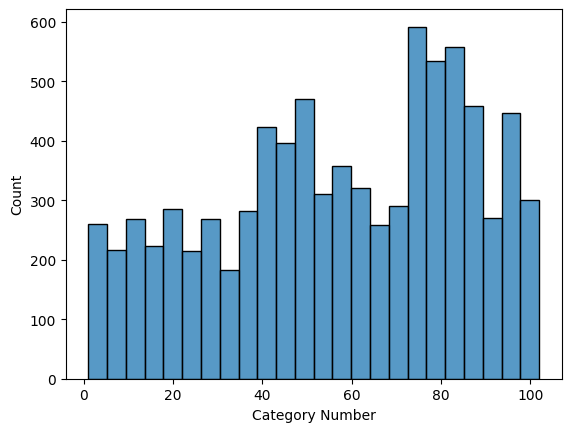

In [5]:
# Counting the labels and making a histogram to see their frequency
labels = loadmat('imagelabels.mat')['labels'].squeeze()
sns.histplot(labels)
plt.xlabel('Category Number')
plt.ylabel('Count')
plt.show()

In [6]:
# Naming the images directory and listing them
images_dir = 'jpg'

# Check if the directory exists
if not os.path.exists(images_dir):
    raise FileNotFoundError(f"The directory '{images_dir}' does not exist.")

images = os.listdir(images_dir)

num_to_cat = {
    "21": "fire lily",
    "3": "canterbury bells",
    "45": "bolero deep blue",
    "1": "pink primrose",
    "34": "mexican aster",
    "27": "prince of wales feathers",
    "7": "moon orchid",
    "16": "globe-flower",
    "25": "grape hyacinth",
    "26": "corn poppy",
    "79": "toad lily",
    "39": "siam tulip",
    "24": "red ginger",
    "67": "spring crocus",
    "35": "alpine sea holly",
    "32": "garden phlox",
    "10": "globe thistle",
    "6": "tiger lily",
    "93": "ball moss",
    "33": "love in the mist",
    "9": "monkshood",
    "102": "blackberry lily",
    "14": "spear thistle",
    "19": "balloon flower",
    "100": "blanket flower",
    "13": "king protea",
    "49": "oxeye daisy",
    "15": "yellow iris",
    "61": "cautleya spicata",
    "31": "carnation",
    "64": "silverbush",
    "68": "bearded iris",
    "63": "black-eyed susan",
    "69": "windflower",
    "62": "japanese anemone",
    "20": "giant white arum lily",
    "38": "great masterwort",
    "4": "sweet pea",
    "86": "tree mallow",
    "101": "trumpet creeper",
    "42": "daffodil",
    "22": "pincushion flower",
    "2": "hard-leaved pocket orchid",
    "54": "sunflower",
    "66": "osteospermum",
    "70": "tree poppy",
    "85": "desert-rose",
    "99": "bromelia",
    "87": "magnolia",
    "5": "english marigold",
    "92": "bee balm",
    "28": "stemless gentian",
    "97": "mallow",
    "57": "gaura",
    "40": "lenten rose",
    "47": "marigold",
    "59": "orange dahlia",
    "48": "buttercup",
    "55": "pelargonium",
    "36": "ruby-lipped cattleya",
    "91": "hippeastrum",
    "29": "artichoke",
    "71": "gazania",
    "90": "canna lily",
    "18": "peruvian lily",
    "98": "mexican petunia",
    "8": "bird of paradise",
    "30": "sweet william",
    "17": "purple coneflower",
    "52": "wild pansy",
    "84": "columbine",
    "12": "colt's foot",
    "11": "snapdragon",
    "96": "camellia",
    "23": "fritillary",
    "50": "common dandelion",
    "44": "poinsettia",
    "53": "primula",
    "72": "azalea",
    "65": "californian poppy",
    "80": "anthurium",
    "76": "morning glory",
    "37": "cape flower",
    "56": "bishop of llandaff",
    "60": "pink-yellow dahlia",
    "82": "clematis",
    "58": "geranium",
    "75": "thorn apple",
    "41": "barbeton daisy",
    "95": "bougainvillea",
    "43": "sword lily",
    "83": "hibiscus",
    "78": "lotus lotus",
    "88": "cyclamen",
    "94": "foxglove",
    "81": "frangipani",
    "74": "rose",
    "89": "watercress",
    "73": "water lily",
    "46": "wallflower",
    "77": "passion flower",
    "51": "petunia"
}

In [7]:
# Copying images from `jpg` directory to `data` directory while classifying
# them according to the class
for i, image in tqdm(enumerate(images), total=len(labels)):
    num = int(image.split('_')[1].split('.')[0])
    label_folder = os.path.join('data', str(labels[num-1]))
    os.makedirs(label_folder, exist_ok=True)
    old_path = os.path.join(images_dir, image)
    new_path = os.path.join(label_folder, image)
    try:
        shutil.copy(old_path, new_path)
    except Exception as e:
        print(f"Error copying {old_path} to {new_path}: {e}")

shutil.rmtree('jpg')
images_dir = 'data'

  0%|          | 0/8189 [00:00<?, ?it/s]

In [8]:
def plot_random_flower_types(num_types):
    """
    Creating a function that takes the number of types of flowers we want
    to see and show four samples from each random folder.
    """
    folders = np.random.randint(1, 102, num_types)
    for folder in folders:
        folder_path = os.path.join(images_dir, str(folder))
        if not os.path.exists(folder_path):
            print(f"Folder {folder_path} does not exist.")
            continue
        images = os.listdir(folder_path)[:4]
        for i, image in enumerate(images):
            img_path = os.path.join(folder_path, image)
            if not os.path.isfile(img_path):
                print(f"Image {img_path} does not exist.")
                continue
            img = plt.imread(img_path)
            plt.subplot(1, 4, i + 1)
            plt.title(f"Folder {folder}")
            plt.imshow(img)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

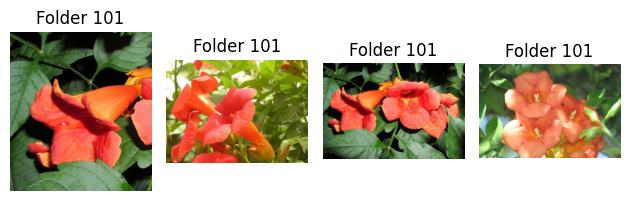

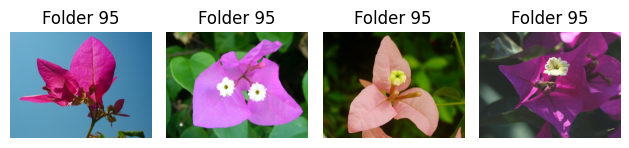

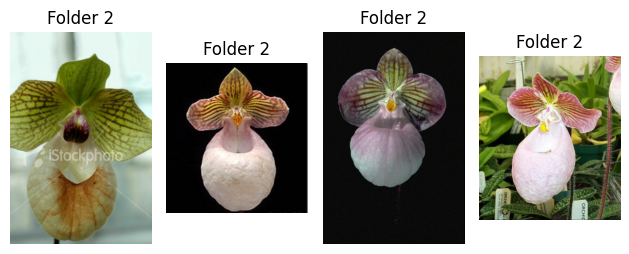

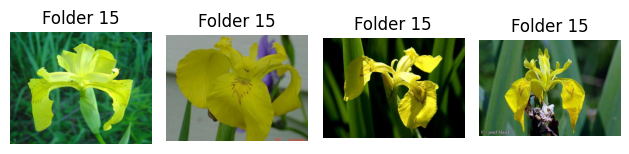

In [9]:
plot_random_flower_types(4)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
# Creating transforms to better control the images in the model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [12]:
dataset = ImageFolder(images_dir, transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 8189
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [13]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [14]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
len(train_loader),len(val_loader)

(410, 103)

# Creating Model

In [15]:
model = models.resnet50(pretrained=True)

# Freeze the weights of the ResNet50 model
for param in model.parameters():
    param.requires_grad = False

num_classes = 102
model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.0003, momentum=0.9)

#Training Model

In [17]:
num_epochs = 50

model.to(device)

train_metrics = {'loss': [], 'accuracy': []}
test_metrics = {'loss': [], 'accuracy': []}

for epoch in tqdm(range(num_epochs), total=num_epochs, desc="Training Model"):
    # Training
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print and log statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Training loss: {loss.item():.4f}')
            logging.info(f'Epoch {epoch + 1}, Batch {i + 1}, Training loss: {loss.item():.4f}')

    # Calculate training metrics and store them in dictionary
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_metrics['loss'].append(epoch_loss)
    train_metrics['accuracy'].append(epoch_acc)
    print(f'Epoch {epoch + 1} training loss: {epoch_loss:.4f} accuracy: {epoch_acc:.4f}')
    logging.info(f'Epoch {epoch + 1} training loss: {epoch_loss:.4f} accuracy: {epoch_acc:.4f}')

    # Validation
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 30 == 29:
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Validation loss: {loss.item():.4f}')
                logging.info(f'Epoch {epoch + 1}, Batch {i + 1}, Validation loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct / total
    test_metrics['loss'].append(epoch_loss)
    test_metrics['accuracy'].append(epoch_acc)
    print(f'Test loss: {epoch_loss:.4f} accuracy: {epoch_acc:.4f}')
    logging.info(f'Test loss: {epoch_loss:.4f} accuracy: {epoch_acc:.4f}')

Training Model:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1, Batch 100, Training loss: 4.3732
Epoch 1, Batch 200, Training loss: 3.8524
Epoch 1, Batch 300, Training loss: 3.8009
Epoch 1, Batch 400, Training loss: 3.6437
Epoch 1 training loss: 4.1927 accuracy: 0.1308
Epoch 1, Batch 30, Validation loss: 3.5077
Epoch 1, Batch 60, Validation loss: 4.0555
Epoch 1, Batch 90, Validation loss: 3.5845
Test loss: 3.8409 accuracy: 0.2247
Epoch 2, Batch 100, Training loss: 3.4787
Epoch 2, Batch 200, Training loss: 3.2877
Epoch 2, Batch 300, Training loss: 3.1794
Epoch 2, Batch 400, Training loss: 3.1762
Epoch 2 training loss: 3.5040 accuracy: 0.3296
Epoch 2, Batch 30, Validation loss: 2.9953
Epoch 2, Batch 60, Validation loss: 3.4383
Epoch 2, Batch 90, Validation loss: 2.9861
Test loss: 3.2675 accuracy: 0.4072
Epoch 3, Batch 100, Training loss: 3.0255
Epoch 3, Batch 200, Training loss: 2.7643
Epoch 3, Batch 300, Training loss: 2.8943
Epoch 3, Batch 400, Training loss: 2.6746
Epoch 3 training loss: 2.9737 accuracy: 0.4654
Epoch 3, Batch 30, Validati

# Plotting Results


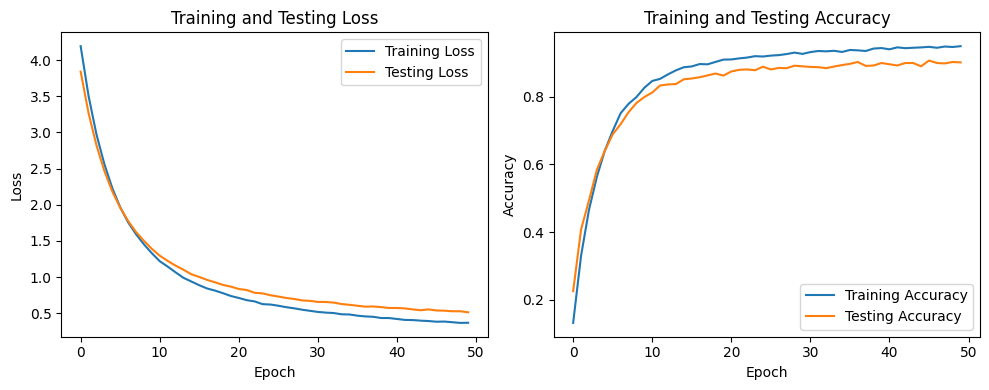

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Plot training and testing loss
plt.subplot(121)
plt.plot(train_metrics['loss'], label='Training Loss')
plt.plot(test_metrics['loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')

# Plot training and testing accuracy
plt.subplot(122)
plt.plot(train_metrics['accuracy'], label='Training Accuracy')
plt.plot(test_metrics['accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')

plt.tight_layout()
plt.show()


# Project Outcome: ResNet50 Classification of 102Flowers Dataset
# Performance Summary



  *   Model: ResNet50
  *   Dataset: 102Flowers
  *   Achieved Accuracy: 90.23% (test accuracy)


#Key Observations and Future Directions



1.   Framework Efficiency

      *  PyTorch likely facilitated streamlined model creation and training


2.   Potential Enhancements

      *  Explore hyperparameter optimization for improved accuracy
      *  Implement advanced data augmentation techniques
      *  Investigate performance of alternative ResNet architectures

3.   Dataset Insights
    *   ResNet50 demonstrates strong capability in handling the 102Flowers dataset





